In [38]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import glob
import pandas as pd
import matplotlib.pyplot as plt

Let's try loading in some data using our Dataset

In [40]:
from p2ch10.dsets import Ct, LunaDataset

In [41]:
LunaDataset??

Init signature: LunaDataset(*args, **kwds)
Docstring:     
An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`.

.. note::
  :class:`~torch.utils.data.DataLoader` by default constructs a index
  sampler that yields integral indices.  To make it work with a map-style
  dataset with non-integral indices/keys, a custom sampler must be provided.
Source:        
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
            ):
        self.candidateInfo_list = copy.copy(getCandi

## \__init\__

As can be seen from above, the initialiser from for the Luna dataset class expects a single series uid. Let's go find a series uid to use in an example instantiation of this class

In [42]:
candidates = pd.read_csv("./data/part2/luna/candidates.csv")

In [43]:
series_uid_ex = candidates.loc[2000, "seriesuid"]
series_uid_ex

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'

The first thing which happens is we run `getCandidateInfoList`

Let's have a look at what that does

In [44]:
from p2ch10.dsets import getCandidateInfoList

getCandidateInfoList??

Signature:       getCandidateInfoList(requireOnDisk_bool=True)
Call signature:  getCandidateInfoList(*args, **kwargs)
Type:            _lru_cache_wrapper
String form:     <functools._lru_cache_wrapper object at 0x7f66f4702c10>
File:            ~/projects/dlwpt-code/p2ch10/dsets.py
Source:         
@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    # We construct a set with all series_uids that are present on disk.
    # This will let us use the data, even if we haven't downloaded all of
    # the subsets yet.
    mhd_list = glob.glob('data-unversioned/part2/luna/subset*/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    diameter_dict = {}
    with open('data/part2/luna/annotations.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])

            diameter_dict.setdefaul

This function find all candidate nodules related to a `seriesuid`, performs some cleaning ensuring candidate center is uniform between `candidates.csv` and `annotations.csv` and finally returns a list of named tuples containing information about candidate nodules

In [45]:
single_ct_ex = LunaDataset(series_uid=series_uid_ex)

2022-12-29 12:19:04,727 INFO     pid:10037 p2ch10.dsets:170:__init__ <p2ch10.dsets.LunaDataset object at 0x7f66ed3ec5e0>: 959 training samples


Let's go ahead and look at some of the potential nodules' named tuples

In [46]:
single_ct_ex.candidateInfo_list[0]

CandidateInfoTuple(isNodule_bool=True, diameter_mm=5.786347814, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208', center_xyz=(70.19, -140.93, 877.68))

So the first one in our list is a true nodule and there is some further identifying information

## \__len\__

The `__len__` method is v simple: it just returns the length of `candidateInfo_list`

## \__getitem\__

The first function call in `__getitem__` is `getCtRawCandidate`, let's have a look at how it works

In [47]:
from p2ch10.dsets import getCtRawCandidate

getCtRawCandidate??

Signature: getCtRawCandidate(series_uid, center_xyz, width_irc)
Docstring: <no docstring>
Source:   
@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc
File:      ~/projects/dlwpt-code/p2ch10/dsets.py
Type:      function


In [48]:
from p2ch10.dsets import getCt

getCt??

Signature:       getCt(series_uid)
Call signature:  getCt(*args, **kwargs)
Type:            _lru_cache_wrapper
String form:     <functools._lru_cache_wrapper object at 0x7f66f4702d30>
File:            ~/projects/dlwpt-code/p2ch10/dsets.py
Source:         
@functools.lru_cache(1, typed=True)
def getCt(series_uid):
    return Ct(series_uid)
Class docstring:
Create a cached callable that wraps another function.

user_function:      the function being cached

maxsize:  0         for no caching
          None      for unlimited cache size
          n         for a bounded cache

typed:    False     cache f(3) and f(3.0) as identical calls
          True      cache f(3) and f(3.0) as distinct calls

cache_info_type:    namedtuple class with the fields:
                        hits misses currsize maxsize


In [49]:
from p2ch10.dsets import Ct

Ct??

Init signature: Ct(series_uid)
Docstring:      <no docstring>
Source:        
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob(
            'data-unversioned/part2/luna/subset*/{}.mhd'.format(series_uid)
        )[0]

        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down
        ct_a.clip(-1000, 1000, ct_a)

        self.series_uid = series_uid
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)


Here we can see Ct loads in the entirety of the raw CT scan data. Following this `getRawCandidate` converts the center of a specified nodule into voxel space. Afterwards, the surrounding volume is cut out and returned with some added logic to deal with nodules close to the boundary of the image

Ok, back to `__getitem__` 

After retrieving the raw candidate nodule from the CT scan, `__getitem__` then retrieves the label for the candidate nodule: `pos_t`

Then finally it will return the `seriesuid` and the center of the candidate nodule in voxel space. Let's have at some example outputs

In [58]:
candidate_ex, candidate_label_ex, series_uid_ex, candidate_center_ex = next(
    iter(single_ct_ex)
)

In [59]:
candidate_ex.shape

torch.Size([1, 32, 48, 48])

In [60]:
candidate_label_ex

tensor([0, 1])

In [61]:
series_uid_ex

'1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'

In [62]:
candidate_center_ex

tensor([ 89, 270, 385])

## Visualisation

Great. Now we've understood how our dataset retrieves the nodules from each CT scan, let's go ahead and visualise some of the candidate nodules

In [98]:
%matplotlib inline

2022-12-29 16:46:09,806 INFO     pid:10037 p2ch10.dsets:170:__init__ <p2ch10.dsets.LunaDataset object at 0x7f66e5dc5fa0>: 384840 training samples
2022-12-29 16:46:09,882 INFO     pid:10037 p2ch10.dsets:170:__init__ <p2ch10.dsets.LunaDataset object at 0x7f66e5dc5fa0>: 521 training samples


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
5 CandidateInfoTuple(isNodule_bool=True, dia

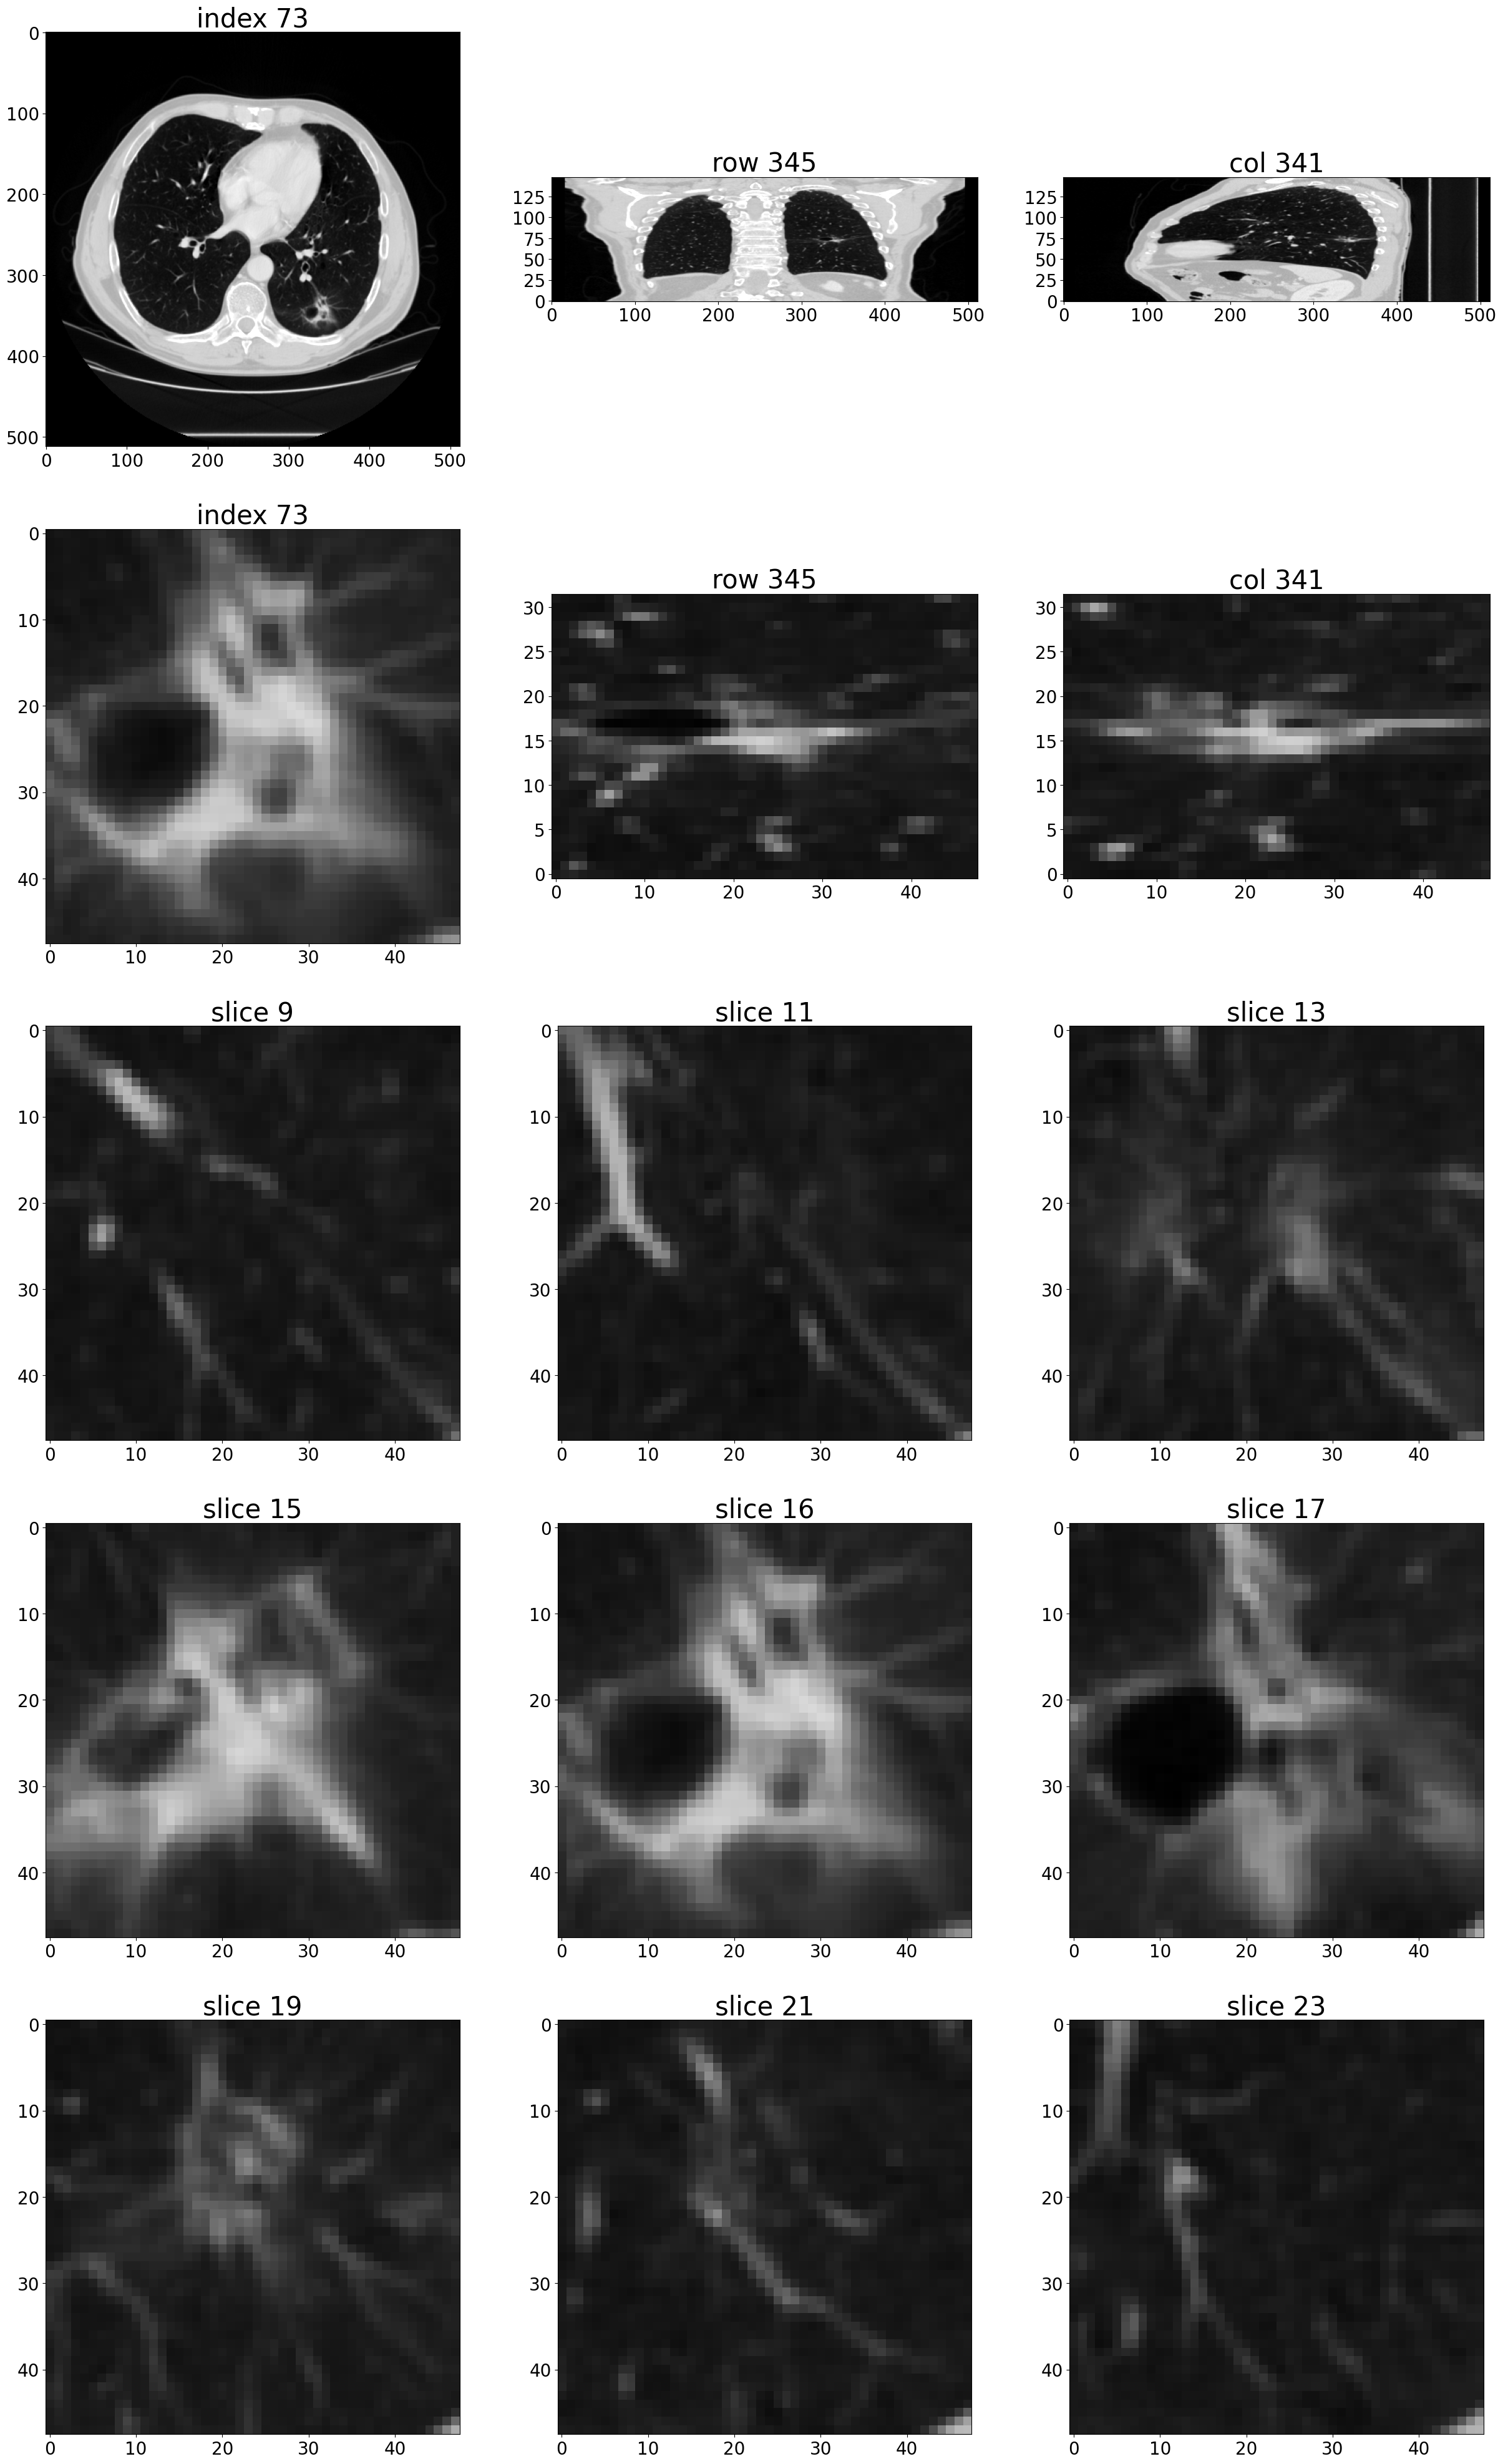

In [99]:
from p2ch10.vis import findPositiveSamples, showCandidate

nodule_sample_list = findPositiveSamples()
series_uid = nodule_sample_list[50].series_uid
showCandidate(series_uid)